## 1.Data collection

In [64]:
import requests
import time
import pandas as pd
from tqdm import tqdm

BASE_URL = "https://api.stackexchange.com/2.3/questions"
ANSWER_URL = "https://api.stackexchange.com/2.3/questions/{ids}/answers"
SITE = "stackoverflow"
TAG = "nlp"
API_KEY = "rl_4wt1zmZCpTgXQfqzhDFWf1Vbj"
PAGE_SIZE = 100
MAX_PAGES = 210
SLEEP_TIME = 0.3

posts = []

# Fetch accepted answer body for a specific question
def get_accepted_answer_body(question_id, accepted_id):
    try:
        url = ANSWER_URL.format(ids=question_id)
        params = {
            "site": SITE,
            "filter": "withbody",
            "key": API_KEY,
            "order": "desc",
            "sort": "votes"
        }
        res = requests.get(url, params=params)
        data = res.json()

        for ans in data.get("items", []):
            if ans.get("answer_id") == accepted_id:
                return ans.get("body", "None")
    except:
        pass
    return "None"

In [60]:
print("🔍 Crawling Stack Overflow posts tagged with [nlp]...")

for page in tqdm(range(1, MAX_PAGES + 1)):
    params = {
        "page": page,
        "pagesize": PAGE_SIZE,
        "order": "desc",
        "sort": "creation",
        "tagged": TAG,
        "site": SITE,
        "filter": "withbody",
        "key": API_KEY
    }

    try:
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        # Handle rate limit or API error
        if "error_id" in data:
            print(f"❌ Error: {data['error_message']}")
            if data["error_name"] == "throttle_violation":
                wait_seconds = int(data["error_message"].split("in ")[1].split(" ")[0])
                print(f"🚨 Rate limit reached. Waiting {wait_seconds} seconds...")
                break
            else:
                time.sleep(5)
                continue

        for item in data.get("items", []):
            q_id = item.get("question_id")
            acc_id = item.get("accepted_answer_id")
            accepted_answer = get_accepted_answer_body(q_id, acc_id)

            posts.append({
                "Title": item.get("title", ""),
                "Description": item.get("body", ""),
                "Tags": item.get("tags", []),
                "AcceptedAnswer": accepted_answer,
                "MoreAcceptedAnswers": "No more accepted answers",
                "CreationDate": item.get("creation_date", ""),
                "ViewCount": item.get("view_count", 0),
                "Score": item.get("score", 0),
                "AnswerCount": item.get("answer_count", 0)
            })

        if not data.get("has_more", False):
            break

        time.sleep(SLEEP_TIME)

    except Exception as e:
        print("❗ Request failed:", str(e))
        break

100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:02<00:00, 94.77it/s]

✅ All posts fetched successfully.


In [217]:
# Save collected results
df = pd.DataFrame(posts)
df.to_csv("stack_overflow_nlp.csv", index=False, encoding="utf-8-sig")
print("✅ Data saved to stack_overflow_nlp.csv")

✅ Data saved to stack_overflow_nlp.csv


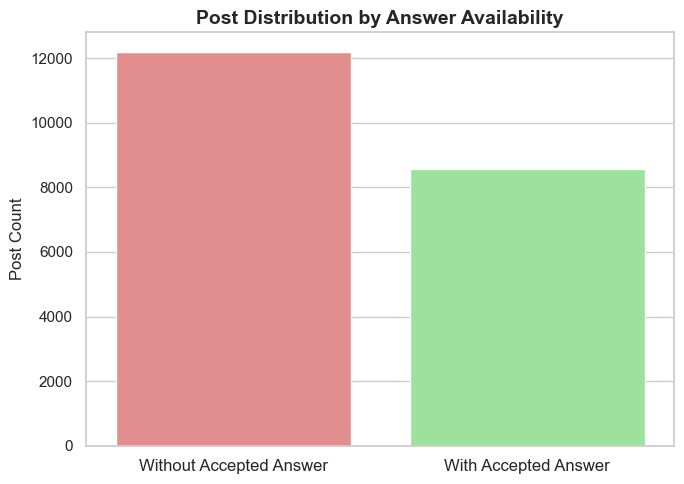

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("stack_overflow_nlp_categorised.csv")

df["HasAcceptedAnswer"] = df["AcceptedAnswer"].notna()

df["AnswerLabel"] = df["HasAcceptedAnswer"].map({True: "With Accepted Answer", False: "Without Accepted Answer"})

plt.figure(figsize=(7, 5))
sns.set_theme(style="whitegrid")
ax = sns.countplot(data=df, x="AnswerLabel", hue="AnswerLabel", palette=["#F08080", "#90EE90"], legend=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.ylabel("Post Count", fontsize=12)
plt.xlabel("")
plt.title("Post Distribution by Answer Availability", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

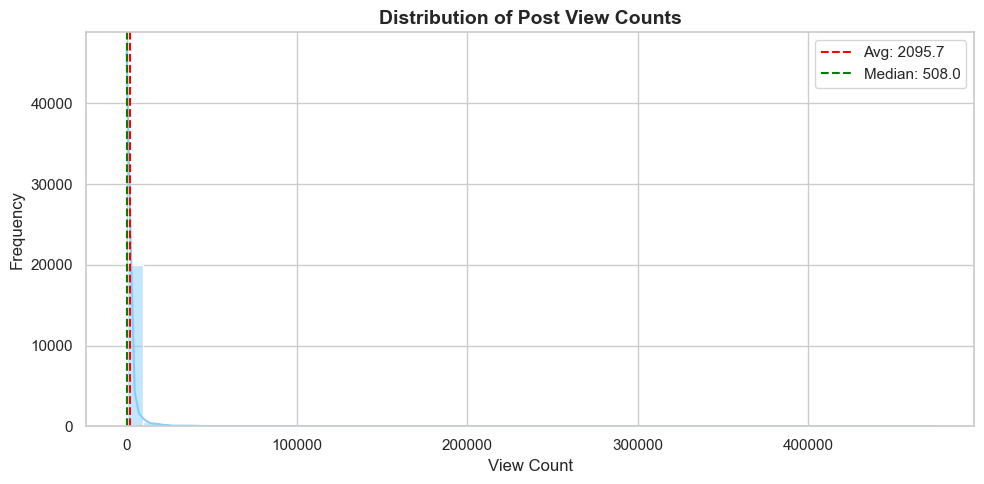

In [68]:
avg_views = df["ViewCount"].mean()
median_views = df["ViewCount"].median()

plt.figure(figsize=(10, 5))
sns.histplot(df["ViewCount"], bins=50, kde=True, color="#87CEFA")

plt.axvline(avg_views, color="red", linestyle="--", label=f"Avg: {avg_views:.1f}")
plt.axvline(median_views, color="green", linestyle="--", label=f"Median: {median_views:.1f}")

plt.title("Distribution of Post View Counts", fontsize=14, weight='bold')
plt.xlabel("View Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

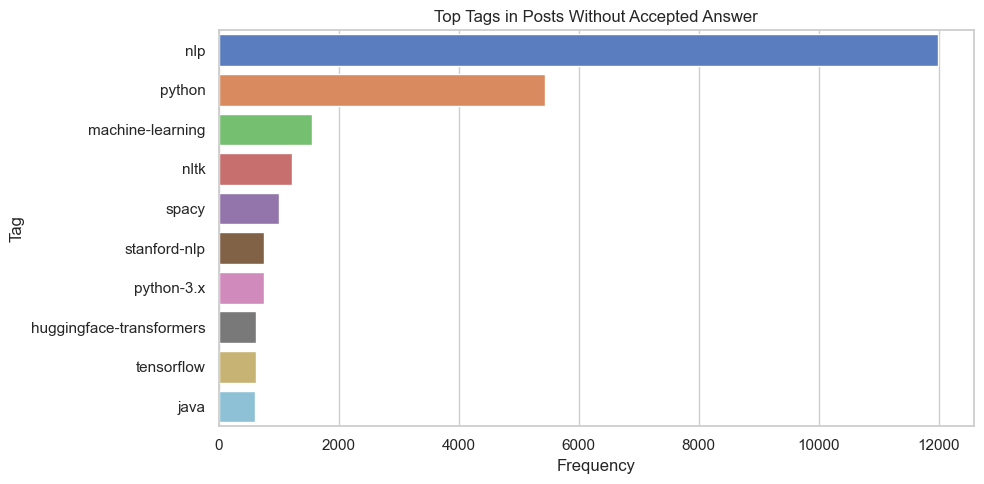

In [70]:
from collections import Counter

# Extract tags from unanswered posts
no_answer_df = df[df["AcceptedAnswer"].isna()]
tags = no_answer_df["Tags"].dropna().tolist()

flat_tags = [tag.strip(" '") for sublist in tags for tag in sublist.strip("[]").split(",")]
top_tags = Counter(flat_tags).most_common(10)

tag_names, tag_counts = zip(*top_tags)

tag_df = pd.DataFrame({"Tag": tag_names, "Count": tag_counts})
plt.figure(figsize=(10, 5))
sns.barplot(data=tag_df, x="Count", y="Tag", hue="Tag", dodge=False, palette="muted", legend=False)

plt.xlabel("Frequency")
plt.ylabel("Tag")
plt.title("Top Tags in Posts Without Accepted Answer")
plt.tight_layout()
plt.show()

## 2.Pre-processing

In [73]:
import re
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [75]:
# NLTK Resource Setup
#nltk.download("punkt")
#nltk.download("stopwords")
#nltk.download("wordnet")

# Initialization
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Load Dataset
df = pd.read_csv("stack_overflow_nlp.csv")
import nltk
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

True

In [79]:
import warnings
from bs4 import MarkupResemblesLocatorWarning

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
# Preprocessing Function
def clean_text(text):
    if pd.isna(text):
        return ""
    # 1. Remove HTML tags (including images, code blocks)
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Convert to lowercase
    text = text.lower()

    # 3. Remove code blocks (both <code>...</code> and Markdown `...`)
    text = re.sub(r"<code>.*?</code>", "", text, flags=re.DOTALL)
    text = re.sub(r"`[^`]*`", "", text)
    text = re.sub(r"http\S+|www\S+|screenshot|image", "", text)

    # 4. Remove punctuation and special symbols
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # 5. Tokenization
    tokens = word_tokenize(text)

    # 6. Remove stopwords, single characters, and apply lemmatization
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 1
    ]

    return " ".join(tokens)

In [81]:
# Apply Preprocessing
print("🔄 Cleaning 'Title' column...")
df["Cleaned_Title"] = df["Title"].apply(clean_text)

print("🔄 Cleaning 'Description' column...")
df["Cleaned_Description"] = df["Description"].apply(clean_text)

print("🔄 Cleaning 'AcceptedAnswer' column...")
df["Cleaned_Answer"] = df["AcceptedAnswer"].apply(clean_text)

🔄 Cleaning 'Title' column...
🔄 Cleaning 'Description' column...
🔄 Cleaning 'AcceptedAnswer' column...


In [33]:
# Save the Cleaned Dataset
df.to_csv("stack_overflow_nlp_cleaned.csv", index=False, encoding="utf-8-sig")
print("✅ Cleaning complete. Saved as 'stack_overflow_nlp_cleaned.csv'")

✅ Cleaning complete. Saved as 'stack_overflow_nlp_cleaned.csv'


## 3.Graphical representation of the dataset

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [36]:
# Load Cleaned Dataset
df = pd.read_csv("stack_overflow_nlp_cleaned.csv")

# Define Custom Stopwords (Noise Words)
custom_stopwords = {"text", "model", "word", "using", "python", "error", "use", "get"}

# Concatenate All Cleaned Titles
titles = df["Cleaned_Title"].dropna().tolist()
text = " ".join(titles)

In [37]:
# Generate Word Cloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    max_words=100,
    collocations=False, 
    stopwords=custom_stopwords
).generate(text)

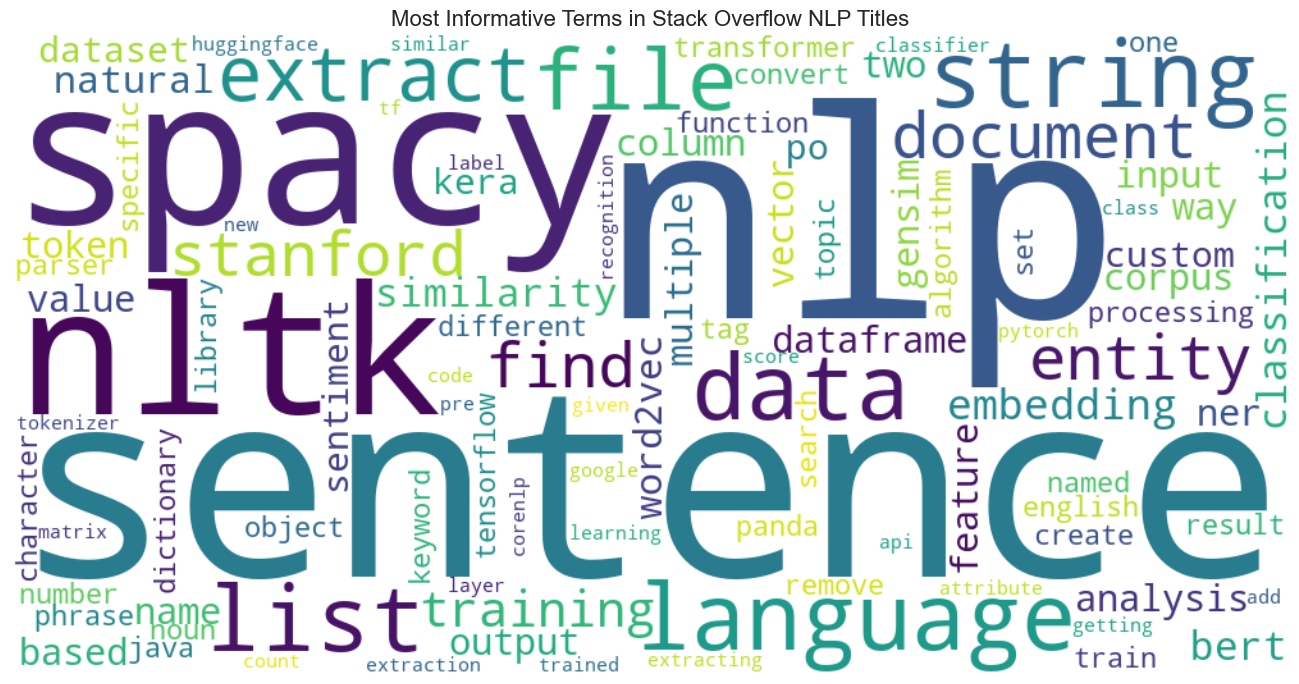

In [38]:
# Display Word Cloud
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Informative Terms in Stack Overflow NLP Titles", fontsize=16)
plt.tight_layout()
plt.show()

## 4.Categorisation of the posts

In [40]:
from collections import Counter
# Load Cleaned Stack Overflow Data
df = pd.read_csv("stack_overflow_nlp_cleaned.csv")

In [41]:
# Define Rule-Based Categorisation Function
def categorise_post(title):
    title = str(title).lower()

    rules = [
        # Implementation Issues
        ("implementation_issue", [
            "how", "can i", "issue", "problem", "error", "debug", "run", "install", "fail", 
            "fix", "unable", "crash", "why", "what is wrong", "won't run", "throw error"
        ]),
        # Tokenization
        ("tokenization", [
            "tokenize", "tokenizer", "tokenisation", "split", "parse", "separate", "detokenize"
        ]),
        # Text Similarity
        ("text_similarity", [
            "similarity", "cosine", "distance", "compare", "match", "semantic", "difference"
        ]),
        # Text Classification
        ("text_classification", [
            "classification", "classify", "label", "category", "predict", "intent", 
            "multiclass", "assign tag", "spam detection"
        ]),
        # Text Generation
        ("text_generation", [
            "generate", "generation", "gpt", "output text", "language model", "text generation"
        ]),
        # Sentiment Analysis
        ("sentiment_analysis", [
            "sentiment", "emotion", "opinion", "positive", "negative", "sarcasm"
        ]),
        # Preprocessing
        ("preprocessing", [
            "preprocess", "clean", "stopword", "lemmatize", "stem", "lowercase", 
            "remove punctuation", "normalize", "convert", "format"
        ]),
        # Language Identification
        ("language_identification", [
            "language detection", "detect language"
        ]),
        # Library Specific
        ("library_specific", [
            "nltk", "spacy", "bert", "huggingface", "hugging face", "transformers", 
            "gensim", "word2vec", "word2 vec", "fasttext", "tensorflow"
        ])
    ]

    for category, keywords in rules:
        for keyword in keywords:
            if keyword in title:
                return category

    return "other"

    return "; ".join(categories)

In [42]:
# Apply Categorisation to Each Title
df["Category"] = df["Cleaned_Title"].apply(categorise_post)

In [43]:
rare_counts = df["Category"].value_counts()
rare_to_other = rare_counts[rare_counts < 10].index.tolist()
df["Category"] = df["Category"].apply(lambda x: "other" if x in rare_to_other else x)

In [44]:
# Print Category Statistics (Optional)
print("📊 Category Distribution:")
print(df["Category"].value_counts())

📊 Category Distribution:
Category
other                      10035
library_specific            2540
implementation_issue        2491
text_similarity             1331
text_classification         1193
tokenization                1167
preprocessing               1137
text_generation              469
sentiment_analysis           382
language_identification       25
Name: count, dtype: int64


In [45]:
# Save Categorised Dataset
df.to_csv("stack_overflow_nlp_categorised.csv", index=False, encoding="utf-8-sig")
print("✅ Categorisation completed. Results saved to stack_overflow_nlp_categorised.csv")

✅ Categorisation completed. Results saved to stack_overflow_nlp_categorised.csv


In [46]:
df = pd.read_csv("stack_overflow_nlp_categorised.csv")
df = df[df["Title"].notna() & df["Category"].notna()]

# Output examples per category
for category in df["Category"].unique():
    print(f"\n📂 Category: {category}")
    examples = df[df["Category"] == category].head(2)["Title"].tolist()
    for title in examples:
        print(f"- {title}")


📂 Category: library_specific
- Can older spaCy models be ported to future spaCy versions?
- Why does Presidio with spacy nlp engine not recognize organizations and PESEL while spaCy does?

📂 Category: other
- Unsupervised Topic Modeling for Short Event Descriptions
- Is there a way to reuse a heavy service across tasks in Airflow?

📂 Category: implementation_issue
- NameError: name &#39;init_empty_weights&#39; is not defined while using hugging face models
- Creating regular expression(s) which finds capitalization errors

📂 Category: preprocessing
- Sentencepiece not generating models after preprocessing (SOLVED)
- Converting data into spacy format &quot;convert_to_spacy_format&quot; in Name entity recognition Model

📂 Category: text_classification
- GPT-2 and other models from huggingface -100 label index for training, instead of pad token
- Why is my BERT model producing NaN loss during training for multi-label classification on imbalanced data?

📂 Category: text_similarity
- Diffe